In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import kagglehub
import joblib
import networkx as nx
from tqdm import tqdm
from  sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
import swifter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [27]:
#  pip install kagglehub
# %pip install tqdm

In [28]:
# Download data from kaggle: https://www.kaggle.com/datasets/kazanova/sentiment140/data
# path = kagglehub.dataset_download("kazanova/sentiment140")

# print("Path to dataset files:", path)

<!-- <p style="color: lightblue;">Sentiment labeling in the dataset:</p>
<ul>
  <li>0 = negative</li>
  <li>2 = neutral</li>
  <li>4 = positive</li>
</ul> -->
Sentiment labeling in the dataset:
- 0 = negative
- 2 = neutral
- 4 = positive

In [29]:
df = pd.read_csv('train.csv', header=None, names=["sentiment", "ids", "date", "flag", "user", "text"])
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [31]:
df.isna().sum()

sentiment    0
ids          0
date         0
flag         0
user         0
text         0
dtype: int64

We then create another dataframe where it only have the columns we will be using :

In [32]:
df_cleaned = df[['sentiment', 'text']]
df_cleaned.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


We will map the labels (0 = negative, 1 = positive)

In [33]:
df_cleaned.sentiment = LabelEncoder().fit_transform(df_cleaned.sentiment)
df_cleaned

C:\Users\dell\AppData\Local\Temp\ipykernel_16212\3272369782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.sentiment = LabelEncoder().fit_transform(df_cleaned.sentiment)


,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


### Let's check the distribution of sentiments:

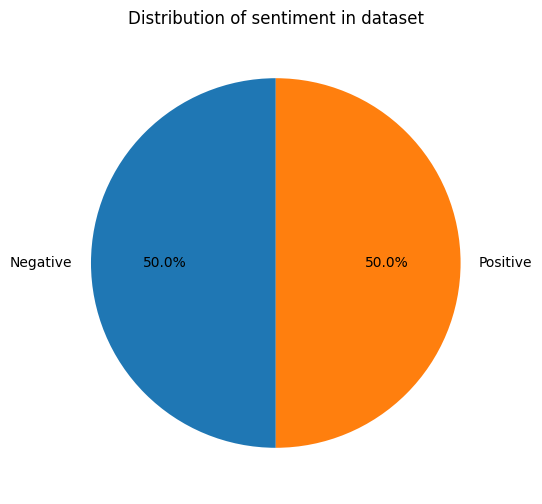

In [34]:

# Pie chart
# Count sentiment values, ensuring no NaNs or invalid entries
sentiment_counts = df_cleaned['sentiment'].value_counts()
labels = sentiment_counts.index.map({0: 'Negative', 1: 'Positive'})

# Pie chart
plt.figure(figsize=(10, 6))
plt.pie(
    sentiment_counts.values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Distribution of sentiment in dataset')
plt.show()

As we can see there is a balance between positive and negative sentiment.

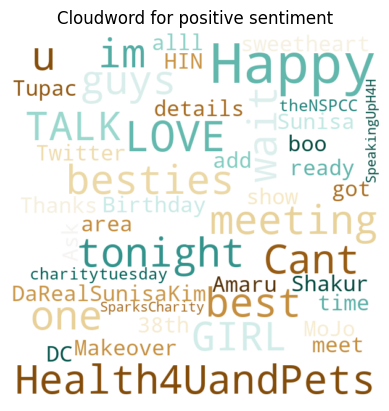

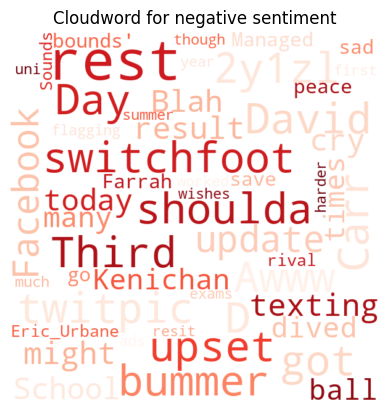

In [78]:
from wordcloud import STOPWORDS
text_positive = str(df_cleaned[df_cleaned['sentiment'] == 1]['text'].values)
text_negative = str(df_cleaned[df_cleaned['sentiment'] == 0]['text'].values)

def plot_word_cloud(text,desc,color) :


    wc = WordCloud(width=600,height=600,background_color="white", max_words=200, stopwords=STOPWORDS,colormap=color,  max_font_size=90,collocations = False, random_state=42)

    wc.generate(text)
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cloudword for {desc}")
    plt.show()


plot_word_cloud(text_positive, "positive sentiment", "BrBG")
plot_word_cloud(text_negative, "negative sentiment", "Reds")

# Preprocessing

In [52]:
class TextPreprocessor:
    def __init__(self):
        # Initialize the word lemmatizer and the emojis dictionary
        self.word_lemmatizer = WordNetLemmatizer()
        self.emojis = {
            ':)': 'smile',
             ':-)': 'smile',
             ';d': 'wink',
             ':-E': 'vampire',
             ':(': 'sad',

            ':-(': 'sad',
             ':-<': 'sad',
             ':P': 'raspberry',
             ':O': 'surprised',

            ':-@': 'shocked',
             ':@': 'shocked',
            ':-$': 'confused',
             ':\\': 'annoyed',

            ':#': 'mute',
             ':X': 'mute',
             ':^)': 'smile',
             ':-&': 'confused',
             '$_$': 'greedy',

            '@@': 'eyeroll',
             ':-!': 'confused',
             ':-D': 'smile',
             ':-0': 'yell',
             'O.o': 'confused',

            '<(-_-)>': 'robot',
             'd[-_-]b': 'dj',
             ":'-)": 'sadsmile',
             ';)': 'wink',
             ';D': 'wink',

            ';-)': 'wink',
             'O:-)': 'angel',
            'O*-)': 'angel',
            '(:-D': 'gossip',
             '=^.^=': 'cat',
             ':D':'smile',
            ':\\': 'annoyed',
        }

    def clean_text(self, text):
        """Cleaning text from unwanted elements"""
        # Remove URLs
        text = re.sub(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text)
        # Remove @username
        text = re.sub(r'@\w+', '', text).strip()
        # Remove email addresses
        text = re.sub(r'[\w\.\-\+]+@([\w\-]+\.)+[\w\-]{2,4}', '', text)
        # Remove quoted text
        text = re.sub(r'["\'].*?["\']', '', text)
        # Remove hashtags
        text = re.sub(r'#\w+', '', text)
        # Remove "etc."
        text = re.sub(r'\betc\.?\b', '', text, flags=re.IGNORECASE)

        return text

    def filter_non_english_words(self, text):
        """
        Remove all words that contain non-English characters.
        """
        pattern = r'\b(?:[a-zA-Z]+|EMOJI_[a-zA-Z_]+)\b'
        filtered = re.findall(pattern, text)
        return ' '.join(filtered)

    def reduce_len_text(self, text):
        """Reduce text repetitive letters """
        repeat_regexp = re.compile(r'(.)\1+')
        return repeat_regexp.sub(r'\1', text)


    def extract_features(self, text):
        """
        Extract features: link, mail, quote, etc...
        """
        return {
            'links': len(re.findall(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', text)),
            'emails': len(re.findall(r'[\w\.\-\+]+@([\w\-]+\.)+[\w\-]{2,4}', text)),
            'quotes': len(re.findall(r'["\'].*?["\']', text)),
            'hashtags': len(re.findall(r'#\w+', text)),
            'etc_count': len(re.findall(r'\betc\.?\b', text, flags=re.IGNORECASE)),
            'nb_caracter': len(text)
        }

    def lemmatize_text(self, text):
        """
        Lemmatize the words in the text.
        """
        processed_text = []
        for word in text.split():
            if len(word) > 1:
                lemmatized_word = self.word_lemmatizer.lemmatize(word)
                processed_text.append(lemmatized_word)
        return ' '.join(processed_text)

    def handle_emojies(self, text):
        """Replace emojis with text"""
        for emoji, meaning in self.emojis.items():
            text = text.replace(emoji, "EMOJI_" + meaning)
        return text

    def preprocess(self, text):
        """
        Preprocess using all the previous functions
        """
        features = self.extract_features(text)

        cleaned_text = self.clean_text(text)
        replace_emojie = self.handle_emojies(cleaned_text)
        lemmatized_text = self.lemmatize_text(replace_emojie)
        no_repetition = self.reduce_len_text(lemmatized_text)
        clean = self.filter_non_english_words(no_repetition)
        return clean, features

# pre = TextPreprocessor()
# word = "awwwwww"
# pre.reduce_len_text(word)


In [53]:
pre = TextPreprocessor()

# sample_text = "@user Check out this amazing link: https://example.com #awesome etc. 'Quoted text' email@example.com :D"

# cleaned_text, features = preprocessor.preprocess(sample_text)

# print("Cleaned Text:", cleaned_text)
# print("Features:", features)

df_cleaned['cleaned_text'], df_cleaned['features'] = zip(*df_cleaned['text'].apply(pre.preprocess))

features_df = pd.DataFrame(df_cleaned['features'].tolist())
df_cleaned = pd.concat([df_cleaned, features_df], axis=1).drop('features', axis=1)

# last time run : 11m 46s
# last time run : 13m 9s
# last time tun : 16m 4s


C:\Users\dell\AppData\Local\Temp\ipykernel_16212\970105667.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cleaned_text'], df_cleaned['features'] = zip(*df_cleaned['text'].apply(pre.preprocess))
C:\Users\dell\AppData\Local\Temp\ipykernel_16212\970105667.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cleaned_text'], df_cleaned['features'] = zip(*df_cleaned['text'].apply(pre.preprocess))


In [54]:
df_cleaned

,sentiment,text,cleaned_text,links,emails,quotes,hashtags,etc_count,nb_caracter
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Aw that s bumer You shoulda got David Car of T...,1,0,0,0,0,115
1,0,is upset that he can't update his Facebook by ...,is upset that he can t update his Facebok by t...,0,0,0,0,0,111
2,0,@Kenichan I dived many times for the ball. Man...,dived many time for the bal Managed to save Th...,0,0,0,0,0,89
3,0,my whole body feels itchy and like its on fire,my whole body fel itchy and like it on fire,0,0,0,0,0,47
4,0,"@nationwideclass no, it's not behaving at all....",no itm mad why am here because can t se you al...,0,0,1,0,0,111
...,...,...,...,...,...,...,...,...,...
1599995,1,Just woke up. Having no school is the best fee...,Just woke up Having no schol is the best felin...,0,0,0,0,0,56
1599996,1,TheWDB.com - Very cool to hear old Walt interv...,TheWDB com Very col to hear old Walt interviews,1,0,0,0,0,76
1599997,1,Are you ready for your MoJo Makeover? Ask me f...,Are you ready for your MoJo Makeover Ask me fo...,0,0,0,0,0,57
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...,Hapy Birthday to my bo of al time Tupac Amaru ...,0,0,0,0,0,65


# TF-IDF

In [55]:
tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1, 2))
tfidf.fit(df_cleaned.cleaned_text)


TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

In [56]:
from scipy.sparse import vstack

# Liste pour stocker les matrices TF-IDF par lots
sparse_matrices = []

for i in tqdm(range(0, len(df_cleaned), 10000), desc='Batch processing'):
    batch = df_cleaned.cleaned_text[i:i + 10000]
    tfidf_matrix_batch = tfidf.transform(batch)

    # Ajouter la matrice sparse au tableau
    sparse_matrices.append(tfidf_matrix_batch)

# Concaténer toutes les matrices sparse en une seule
final_sparse_matrix = vstack(sparse_matrices)

# Créer le DataFrame avec la matrice sparse
df_matrix = pd.DataFrame.sparse.from_spmatrix(final_sparse_matrix, columns=tfidf.get_feature_names_out())
df_matrix['label'] = df_cleaned['sentiment']


Batch processing: 100%|██████████| 160/160 [00:39<00:00,  4.06it/s]


<Axes: >

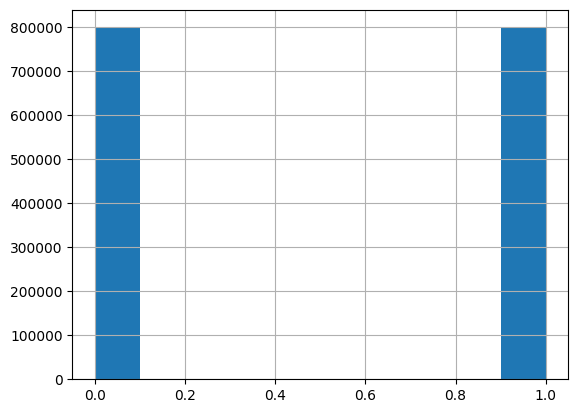

In [57]:
df_matrix.label.hist()

In [58]:
df_matrix

,aa,aa bal,aa bed,aa bely,aa boring,aa bosen,aa canot,aa cofe,aa day,aa dear,...,zzzzzzzz,zzzzzzzz bring,zzzzzzzzz,zzzzzzzzzz,zzzzzzzzzz tired,zzzzzzzzzzz,zzzzzzzzzzz ben,zzzzzzzzzzzz,zzzzzzzzzzzzzz,zzzzzzzzzzzzzz swet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1599996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1599997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1599998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
X= df_matrix.drop(['label'], axis=1)
y= df_matrix.label

# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)
def test_model(model_name, statify):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=statify)
    model = model_name
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print("f1_score: ",f1_score(y_test, y_pred, average='weighted'))


In [ ]:
test_model()

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Réduction de dimension avec SVD
svd = TruncatedSVD(n_components=500, random_state=1)  # Ajustez n_components selon vos ressources
X_reduced = svd.fit_transform(X)


In [ ]:
test_model(RandomForestClassifier(n_jobs=-1), y)

In [61]:
# from sklearn.linear_model import LogisticRegression
# test_model(LogisticRegression(max_iter=1000), y)